In [ ]:
# Trader Risk Management MVP - Analysis Notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings("ignore")

# Import our custom modules
from src.data_loader import DataLoader
from src.simple_feature_engineer import SimpleFeatureEngineer

# from src.personal_lgbm import PersonalizedlgbmModel
from src.lgbm_trader_model import PersonalizedLGBMModel

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Initialize components
print("Initializing data loader and feature engineer...")
data_loader = DataLoader()
feature_engineer = SimpleFeatureEngineer()

# %% [markdown]
# ## 1. Load and Prepare Data

# Load all trader data
print("Loading trader data...")
all_trader_data = data_loader.load_all_traders_data()
master_totals, master_fills = data_loader.create_master_dataset(all_trader_data)

print(f"Loaded data for {len(all_trader_data)} traders")
print(f"Total trading days: {len(master_totals)}")
print(f"Total fills: {len(master_fills)}")

# Display trader summary
trader_summary = (
    master_totals.groupby("account_id")
    .agg({"date": ["min", "max", "count"], "net_pnl": ["sum", "mean", "std"]})
    .round(2)
)
trader_summary.columns = [
    "start_date",
    "end_date",
    "trading_days",
    "total_pnl",
    "avg_daily_pnl",
    "pnl_std",
]
print("\nTrader Summary:")
print(trader_summary)

Initializing data loader and feature engineer...
Loading trader data...


2025-05-26 14:12:15,373 - INFO - Loaded data for 3957: 654 trading days
2025-05-26 14:12:15,780 - INFO - Loaded data for 3950: 471 trading days
2025-05-26 14:12:15,892 - INFO - Loaded data for 3946: 532 trading days
2025-05-26 14:12:16,246 - INFO - Loaded data for 4004: 493 trading days
2025-05-26 14:12:16,339 - INFO - Loaded data for 3951: 338 trading days
2025-05-26 14:12:16,339 - INFO - Successfully loaded data for 5 traders
2025-05-26 14:12:19,163 - INFO - Created master dataset with 1377246 fill records and 14642 total records


Loaded data for 5 traders
Total trading days: 14642
Total fills: 1377246

Trader Summary:
           start_date   end_date  trading_days   total_pnl  avg_daily_pnl  \
account_id                                                                  
3946       2023-04-05 2025-04-30          2158   -18730.81          -8.68   
3950       2023-04-03 2025-04-30          2916   685892.08         235.22   
3951       2023-04-03 2025-04-29           863   -21591.86         -25.02   
3957       2023-04-03 2025-04-30          5554  3972127.00         715.18   
4004       2023-04-17 2025-04-30          3151   259178.73          82.25   

             pnl_std  
account_id            
3946         1563.23  
3950         8241.96  
3951         3324.46  
3957        29751.81  
4004        12791.34  


In [5]:
# %% [markdown]
# ## 2. Feature Engineering

# Engineer features
print("\nEngineering features...")

features_df = feature_engineer.engineer_features(master_totals, master_fills)
feature_columns = feature_engineer.get_feature_columns()

print(f"Total features created: {len(feature_columns)}")
print(f"Feature categories:")
print(
    "- Behavioral signals (5):",
    [
        f
        for f in feature_columns
        if f
        in [
            "trading_frequency",
            "hour_concentration",
            "symbol_diversity",
            "size_inconsistency",
            "morning_bias",
        ]
    ],
)
print(
    "- Essential metrics (10):",
    [
        f
        for f in feature_columns
        if f
        in [
            "net_pnl",
            "gross_pnl",
            "total_fees",
            "fee_ratio",
            "qty",
            "orders_count",
            "avg_fill_size",
            "net_pnl_5d_avg",
            "cum_win_rate",
            "momentum_3d",
        ]
    ],
)
print(
    "- Temporal features (3):",
    [f for f in feature_columns if "day" in f or "monday" in f or "friday" in f],
)

2025-05-26 14:12:19,202 - INFO - Engineering simplified features...



Engineering features...


2025-05-26 14:12:19,831 - INFO - Feature engineering complete. Shape: (14642, 23)


Total features created: 18
Feature categories:
- Behavioral signals (5): ['trading_frequency', 'hour_concentration', 'symbol_diversity', 'size_inconsistency', 'morning_bias']
- Essential metrics (10): ['net_pnl', 'gross_pnl', 'total_fees', 'fee_ratio', 'qty', 'orders_count', 'avg_fill_size', 'net_pnl_5d_avg', 'cum_win_rate', 'momentum_3d']
- Temporal features (3): ['day_of_week', 'is_monday', 'is_friday']


In [ ]:
# %% [markdown]
# ## 3. Train lgbm Models for Each Trader

results_summary = []
all_predictions = []

for trader_id in features_df["account_id"].unique():
    print(f"\n{'='*50}")
    print(f"Training model for trader: {trader_id}")

    # Filter data for this trader
    trader_data = features_df[features_df["account_id"] == trader_id].copy()

    # Split train/test
    train_end_date = features_df.groupby("account_id").get_group(trader_id)[
        "date"
    ].max() - timedelta(days=60)
    train_data = trader_data[trader_data["date"] <= train_end_date]
    test_data = trader_data[trader_data["date"] > train_end_date]

    print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")

    # Initialize and train model
    model = PersonalizedLGBMModel(trader_id)  # instead of PersonalizedlgbmModel
    model.fit(train_data, feature_columns)

    print(f"Best LGBM params: {model.best_params}")

    print(f"Optimal threshold: {model.threshold:.3f}")

    # Make predictions
    predictions = model.predict(test_data)

    # Evaluate
    evaluation = model.evaluate(predictions)
    results_summary.append(evaluation)

    # Store predictions for visualization
    predictions["trader_name"] = all_trader_data[trader_id]["name"]
    all_predictions.append(predictions)

    print(f"\nResults for {all_trader_data[trader_id]['name']}:")
    print(f"  Actual P&L: ${evaluation['actual_total_pnl']:,.2f}")
    print(f"  Signal P&L: ${evaluation['signal_total_pnl']:,.2f}")
    print(
        f"  Improvement: ${evaluation['pnl_improvement']:,.2f} ({evaluation['pnl_improvement_pct']:.1f}%)"
    )
    print(
        f"  Days traded: {evaluation['traded_days']}/{evaluation['total_days']} ({evaluation['trade_reduction_pct']:.1f}% reduction)"
    )
    print(f"  Win rate when trading: {evaluation['win_rate_when_trading']:.1f}%")
    print(f"  Avoided losses: ${evaluation['avoided_losses']:,.2f}")

# Combine all predictions
all_predictions_df = pd.concat(all_predictions, ignore_index=True)


Training model for trader: 3946
Train samples: 2008, Test samples: 150
Optimizing hyperparameters for 3946...
Best LGBM params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05, 'num_leaves': 31, 'min_child_samples': 30, 'subsample': 0.9, 'colsample_bytree': 0.9, 'random_state': 42, 'verbose': -1}
Optimal threshold: 0.350

Results for NET005_OLD:
  Actual P&L: $-21,277.87
  Signal P&L: $-7,638.92
  Improvement: $13,638.94 (64.1%)
  Days traded: 96/150 (36.0% reduction)
  Win rate when trading: 36.5%
  Avoided losses: $17,052.34

Training model for trader: 3950
Train samples: 2620, Test samples: 296
Optimizing hyperparameters for 3950...
Best LGBM params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'num_leaves': 31, 'min_child_samples': 30, 'subsample': 0.9, 'colsample_bytree': 0.9, 'random_state': 42, 'verbose

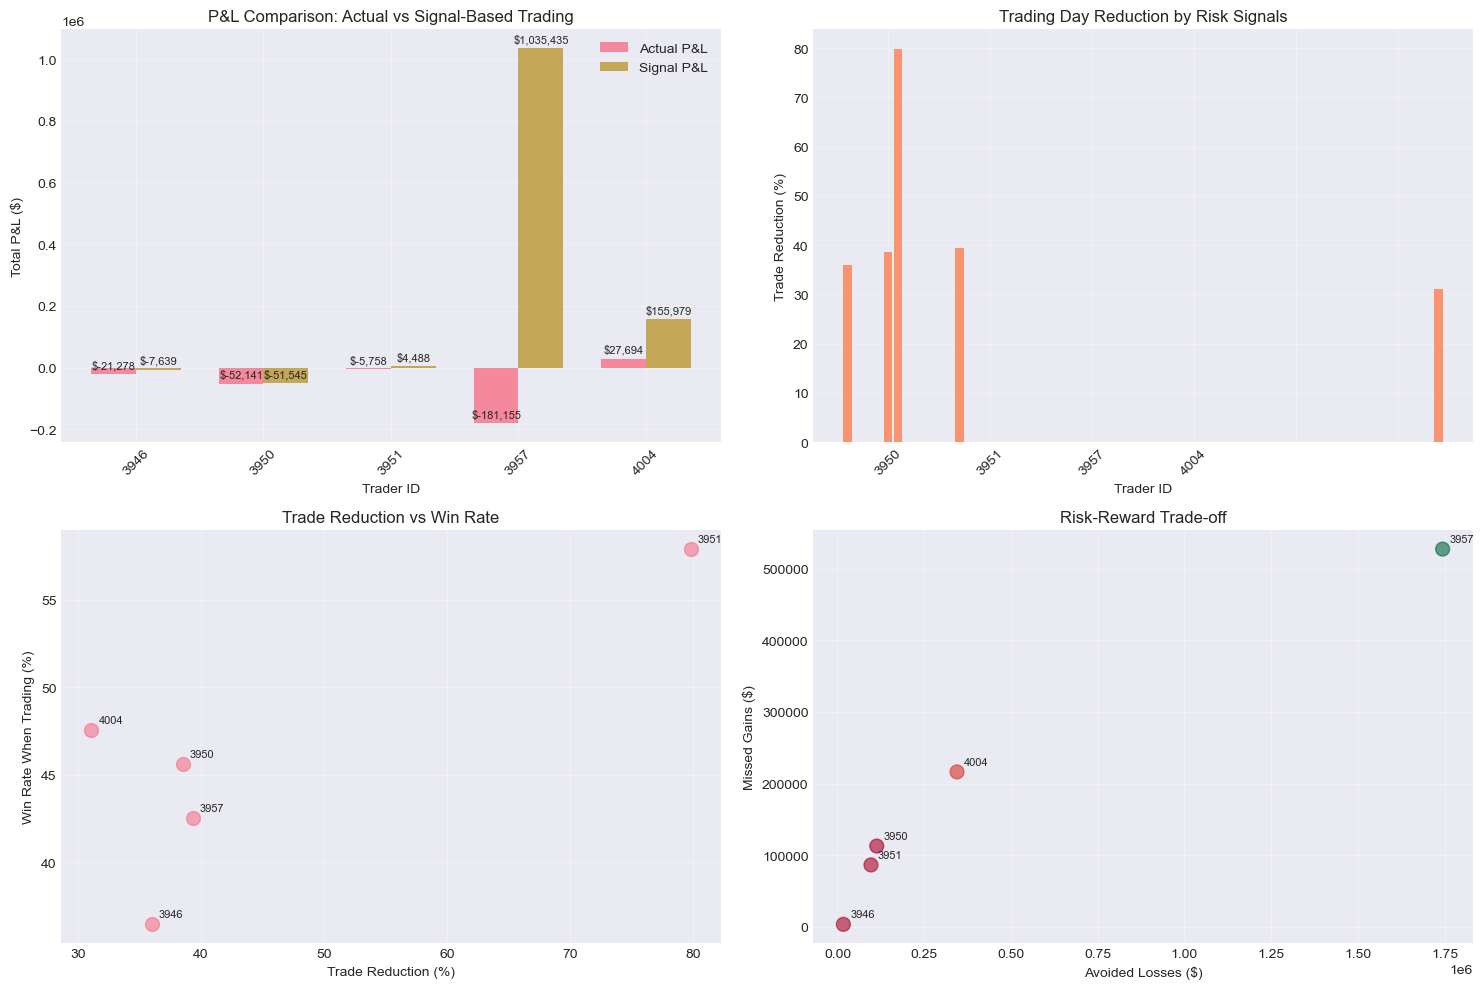

In [7]:
# %% [markdown]
# ## 4. Visualization and Analysis

# Create summary dataframe
results_df = pd.DataFrame(results_summary)

# Overall performance improvement
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. P&L Comparison
ax1 = axes[0, 0]
traders = results_df["trader_id"]
x = np.arange(len(traders))
width = 0.35

bars1 = ax1.bar(
    x - width / 2, results_df["actual_total_pnl"], width, label="Actual P&L", alpha=0.8
)
bars2 = ax1.bar(
    x + width / 2, results_df["signal_total_pnl"], width, label="Signal P&L", alpha=0.8
)

ax1.set_xlabel("Trader ID")
ax1.set_ylabel("Total P&L ($)")
ax1.set_title("P&L Comparison: Actual vs Signal-Based Trading")
ax1.set_xticks(x)
ax1.set_xticklabels(traders, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(
            f"${height:,.0f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
        )

# 2. Risk Reduction
ax2 = axes[0, 1]
ax2.bar(traders, results_df["trade_reduction_pct"], alpha=0.8, color="coral")
ax2.set_xlabel("Trader ID")
ax2.set_ylabel("Trade Reduction (%)")
ax2.set_title("Trading Day Reduction by Risk Signals")
ax2.set_xticklabels(traders, rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Win Rate Analysis
ax3 = axes[1, 0]
ax3.scatter(
    results_df["trade_reduction_pct"],
    results_df["win_rate_when_trading"],
    s=100,
    alpha=0.6,
)
for i, trader in enumerate(traders):
    ax3.annotate(
        trader,
        (
            results_df.iloc[i]["trade_reduction_pct"],
            results_df.iloc[i]["win_rate_when_trading"],
        ),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
    )
ax3.set_xlabel("Trade Reduction (%)")
ax3.set_ylabel("Win Rate When Trading (%)")
ax3.set_title("Trade Reduction vs Win Rate")
ax3.grid(True, alpha=0.3)

# 4. Avoided Losses vs Missed Gains
ax4 = axes[1, 1]
ax4.scatter(
    results_df["avoided_losses"],
    results_df["missed_gains"],
    s=100,
    alpha=0.6,
    c=results_df["pnl_improvement"],
    cmap="RdYlGn",
)
for i, trader in enumerate(traders):
    ax4.annotate(
        trader,
        (results_df.iloc[i]["avoided_losses"], results_df.iloc[i]["missed_gains"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
    )
ax4.set_xlabel("Avoided Losses ($)")
ax4.set_ylabel("Missed Gains ($)")
ax4.set_title("Risk-Reward Trade-off")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

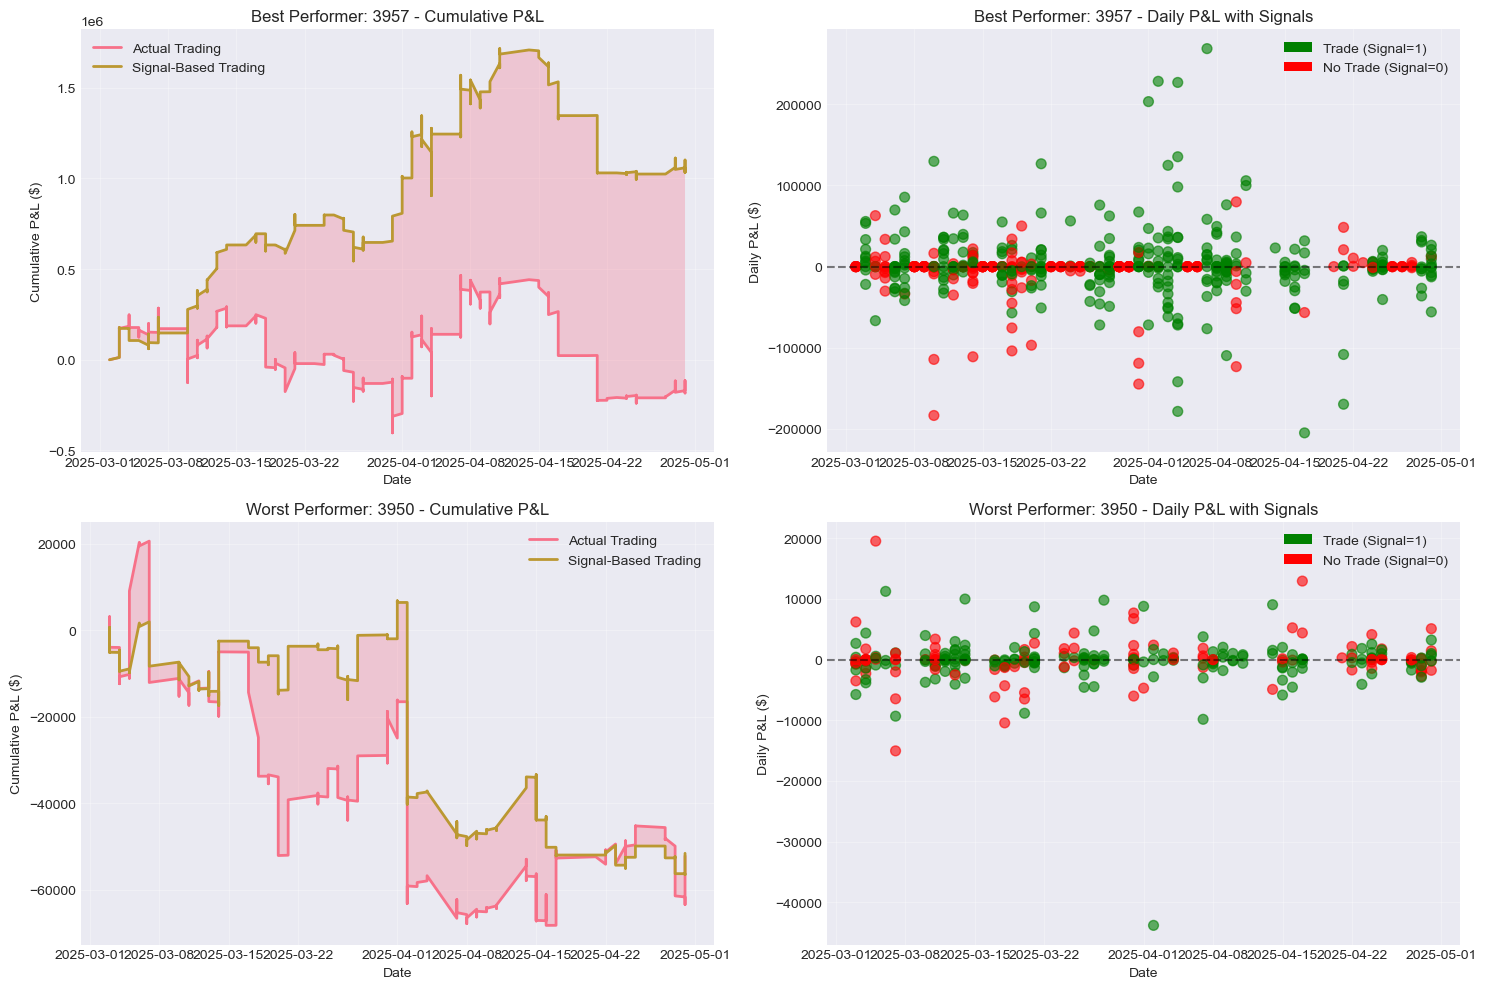

In [8]:
# %% [markdown]
# ## 5. Individual Trader Analysis

# Select best and worst performing traders for detailed analysis
best_trader = results_df.loc[results_df["pnl_improvement"].idxmax(), "trader_id"]
worst_trader = results_df.loc[results_df["pnl_improvement"].idxmin(), "trader_id"]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, (trader_id, label) in enumerate(
    [(best_trader, "Best"), (worst_trader, "Worst")]
):
    trader_predictions = all_predictions_df[
        all_predictions_df["account_id"] == trader_id
    ].copy()
    trader_predictions = trader_predictions.sort_values("date")

    # Cumulative P&L comparison
    ax1 = axes[idx, 0]
    trader_predictions["actual_cumsum"] = trader_predictions["net_pnl"].cumsum()
    trader_predictions["signal_cumsum"] = (
        trader_predictions["net_pnl"] * trader_predictions["trade_signal"]
    ).cumsum()

    ax1.plot(
        trader_predictions["date"],
        trader_predictions["actual_cumsum"],
        label="Actual Trading",
        linewidth=2,
    )
    ax1.plot(
        trader_predictions["date"],
        trader_predictions["signal_cumsum"],
        label="Signal-Based Trading",
        linewidth=2,
    )
    ax1.fill_between(
        trader_predictions["date"],
        trader_predictions["actual_cumsum"],
        trader_predictions["signal_cumsum"],
        alpha=0.3,
    )
    ax1.set_title(f"{label} Performer: {trader_id} - Cumulative P&L")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Cumulative P&L ($)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Trading signals over time
    ax2 = axes[idx, 1]
    colors = ["red" if x == 0 else "green" for x in trader_predictions["trade_signal"]]
    ax2.scatter(
        trader_predictions["date"],
        trader_predictions["net_pnl"],
        c=colors,
        alpha=0.6,
        s=50,
    )
    ax2.axhline(y=0, color="black", linestyle="--", alpha=0.5)
    ax2.set_title(f"{label} Performer: {trader_id} - Daily P&L with Signals")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Daily P&L ($)")
    ax2.grid(True, alpha=0.3)

    # Add legend
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor="green", label="Trade (Signal=1)"),
        Patch(facecolor="red", label="No Trade (Signal=0)"),
    ]
    ax2.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

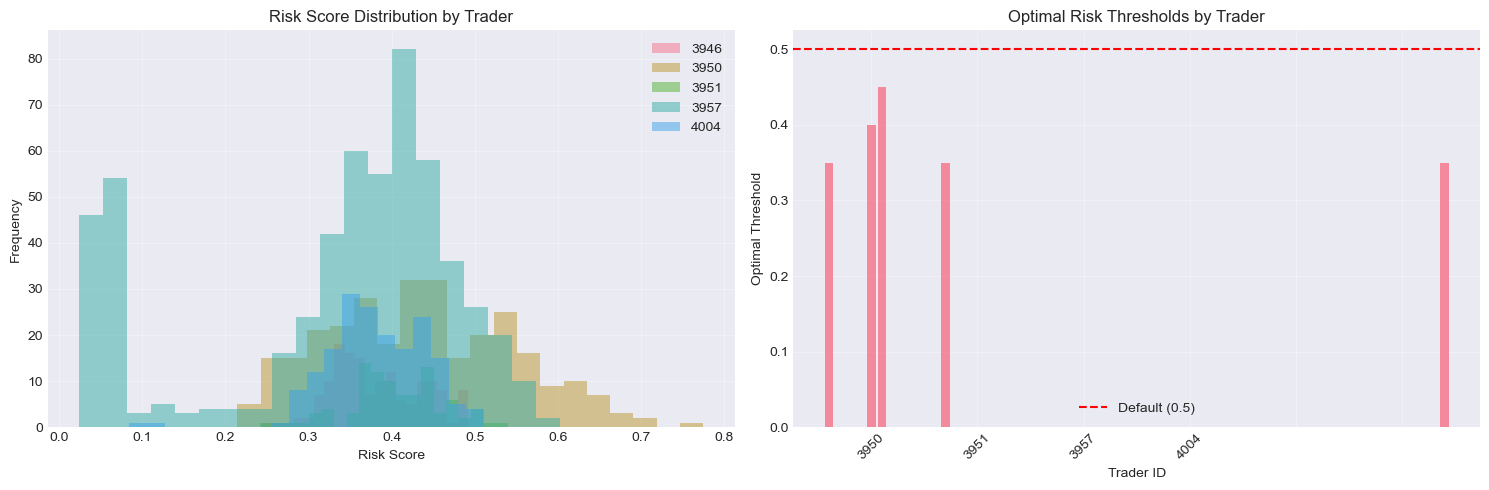

In [9]:
# %% [markdown]
# ## 6. Risk Score Distribution Analysis

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Risk score distribution
ax1 = axes[0]
for trader_id in all_predictions_df["account_id"].unique():
    trader_data = all_predictions_df[all_predictions_df["account_id"] == trader_id]
    ax1.hist(trader_data["risk_score"], alpha=0.5, bins=20, label=trader_id)
ax1.set_xlabel("Risk Score")
ax1.set_ylabel("Frequency")
ax1.set_title("Risk Score Distribution by Trader")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Threshold analysis
ax2 = axes[1]
thresholds = results_df["threshold"].values
ax2.bar(results_df["trader_id"], thresholds, alpha=0.8)
ax2.axhline(y=0.5, color="red", linestyle="--", label="Default (0.5)")
ax2.set_xlabel("Trader ID")
ax2.set_ylabel("Optimal Threshold")
ax2.set_title("Optimal Risk Thresholds by Trader")
ax2.set_xticklabels(results_df["trader_id"], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# %% [markdown]
# ## 7. Summary Report

print("\n" + "=" * 80)
print("TRADER RISK MANAGEMENT MVP - SUMMARY REPORT")
print("=" * 80)

print("\n1. OVERALL PERFORMANCE IMPROVEMENT")
print("-" * 40)
total_actual_pnl = results_df["actual_total_pnl"].sum()
total_signal_pnl = results_df["signal_total_pnl"].sum()
total_improvement = total_signal_pnl - total_actual_pnl
print(f"Total Actual P&L (all traders): ${total_actual_pnl:,.2f}")
print(f"Total Signal P&L (all traders): ${total_signal_pnl:,.2f}")
print(
    f"Total Improvement: ${total_improvement:,.2f} ({(total_improvement/abs(total_actual_pnl))*100:.1f}%)"
)

print("\n2. RISK REDUCTION METRICS")
print("-" * 40)
avg_trade_reduction = results_df["trade_reduction_pct"].mean()
total_avoided_losses = results_df["avoided_losses"].sum()
total_missed_gains = results_df["missed_gains"].sum()
print(f"Average Trade Reduction: {avg_trade_reduction:.1f}%")
print(f"Total Avoided Losses: ${total_avoided_losses:,.2f}")
print(f"Total Missed Gains: ${total_missed_gains:,.2f}")
print(f"Net Benefit: ${total_avoided_losses - total_missed_gains:,.2f}")

print("\n3. INDIVIDUAL TRADER RECOMMENDATIONS")
print("-" * 40)
for _, row in results_df.iterrows():
    trader_name = all_trader_data[row["trader_id"]]["name"]
    if row["pnl_improvement"] > 0:
        recommendation = "IMPLEMENT RISK SIGNALS"
        color = "✅"
    else:
        recommendation = "REVIEW STRATEGY"
        color = "⚠️"

    print(f"\n{color} {trader_name} ({row['trader_id']})")
    print(
        f"   - P&L Impact: ${row['pnl_improvement']:,.2f} ({row['pnl_improvement_pct']:.1f}%)"
    )
    print(f"   - Optimal Threshold: {row['threshold']:.3f}")
    print(f"   - Trade Reduction: {row['trade_reduction_pct']:.1f}%")
    print(f"   - Win Rate: {row['win_rate_when_trading']:.1f}%")
    print(f"   - Recommendation: {recommendation}")

print("\n4. KEY BEHAVIORAL INSIGHTS")
print("-" * 40)

# Analyze feature importance by looking at correlation with target
feature_importance = []
for col in feature_columns:
    corr = features_df[[col, "target"]].corr().iloc[0, 1]
    feature_importance.append({"feature": col, "correlation": abs(corr)})

feature_importance_df = pd.DataFrame(feature_importance).sort_values(
    "correlation", ascending=False
)
print("\nTop 5 Most Predictive Features:")
for idx, row in feature_importance_df.head(5).iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['correlation']:.3f}")

print("\n5. IMPLEMENTATION RECOMMENDATIONS")
print("-" * 40)
print("✓ Implement automated risk signals for traders showing positive improvement")
print("✓ Focus on reducing trading frequency for emotional traders")
print("✓ Monitor morning vs afternoon trading patterns")
print("✓ Review fee structures for high-fee-ratio traders")
print(
    f"✓ Consider {avg_trade_reduction:.0f}% reduction in trading days as baseline target"
)

print("\n" + "=" * 80)
print("END OF REPORT")
print("=" * 80)


TRADER RISK MANAGEMENT MVP - SUMMARY REPORT

1. OVERALL PERFORMANCE IMPROVEMENT
----------------------------------------
Total Actual P&L (all traders): $-232,637.00
Total Signal P&L (all traders): $1,136,718.27
Total Improvement: $1,369,355.27 (588.6%)

2. RISK REDUCTION METRICS
----------------------------------------
Average Trade Reduction: 45.0%
Total Avoided Losses: $2,315,488.13
Total Missed Gains: $946,132.86
Net Benefit: $1,369,355.27

3. INDIVIDUAL TRADER RECOMMENDATIONS
----------------------------------------

✅ NET005_OLD (3946)
   - P&L Impact: $13,638.94 (64.1%)
   - Optimal Threshold: 0.350
   - Trade Reduction: 36.0%
   - Win Rate: 36.5%
   - Recommendation: IMPLEMENT RISK SIGNALS

✅ NET009_OLD (3950)
   - P&L Impact: $595.80 (1.1%)
   - Optimal Threshold: 0.400
   - Trade Reduction: 38.5%
   - Win Rate: 45.6%
   - Recommendation: IMPLEMENT RISK SIGNALS

✅ NET010_OLD (3951)
   - P&L Impact: $10,245.72 (177.9%)
   - Optimal Threshold: 0.450
   - Trade Reduction: 79.8%


In [12]:
# %% [markdown]
# ## 8. Export Results for Production

# Save model parameters and thresholds
model_params = results_df[["trader_id", "threshold", "best_params"]].to_dict("records")

# Save to CSV for easy implementation
results_df.to_csv("trader_risk_results.csv", index=False)
all_predictions_df.to_csv("trader_predictions.csv", index=False)

print("\nResults saved to:")
print("- trader_risk_results.csv")
print("- trader_predictions.csv")

# Create implementation guide
implementation_guide = {
    "model_parameters": model_params,
    "feature_list": feature_columns,
    "behavioral_signals": [
        "trading_frequency",
        "hour_concentration",
        "symbol_diversity",
        "size_inconsistency",
        "morning_bias",
    ],
    "risk_thresholds": {
        row["trader_id"]: row["threshold"] for _, row in results_df.iterrows()
    },
}

import json

with open("implementation_guide.json", "w") as f:
    json.dump(implementation_guide, f, indent=2)

print("- implementation_guide.json")
print("\n✅ MVP Complete! Ready for production implementation.")


Results saved to:
- trader_risk_results.csv
- trader_predictions.csv
- implementation_guide.json

✅ MVP Complete! Ready for production implementation.
